In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color

%matplotlib inline

In [3]:
boys_train_df = pd.read_csv('boys_train.csv')
girls_train_df = pd.read_csv('girls_train.csv')

In [4]:
def get_file_list(df, folder, n_sample = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list
boys_display_files = get_file_list(boys_train_df, 'boys', 400)
girls_display_files = get_file_list(girls_train_df, 'girls', 400)
print(boys_display_files[:5])

['boys/13102.jpg', 'boys/9968.jpg', 'boys/1152.jpg', 'boys/6544.jpg', 'boys/2178.jpg']


In [5]:
def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    img = transform.resize(img, (w, h), mode='constant', anti_aliasing=True)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :]
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

boys_display_images = read_images_4d_array(boys_display_files)
girls_display_images = read_images_4d_array(girls_display_files)
print(boys_display_images.shape)

(400, 100, 100, 3)


## Displaying Grid of Random 400 Images

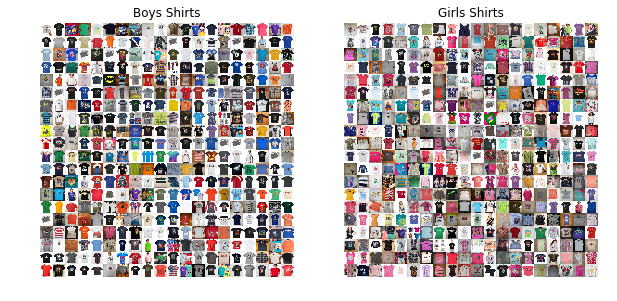

In [6]:
def merge_images(image_batch, size = [20, 20]):
    h,w = image_batch.shape[1], image_batch.shape[2]
    c = image_batch.shape[3]
    img = np.zeros((int(h*size[0]), w*size[1], c))
    for idx, im in enumerate(image_batch):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = im
    return img

boys_merged = merge_images(boys_display_images)
girls_merged = merge_images(girls_display_images)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Boys Shirts')
plt.axis('off')
plt.imshow(boys_merged)

plt.subplot(1, 2, 2)
plt.title('Girls Shirts')
plt.axis('off')
plt.imshow(girls_merged)

Definitely much more pink in girls shirts, much more blue in boys shirts, I'd say equal number of red.

## Color Histograms

In [7]:
def plot_hist_normed(images, channel, col):
    vals = images[:, :, :, channel].flatten()
    plt.hist(vals, weights = np.ones_like(vals) / len(vals), color = col)
    plt.ylim([0, 0.3])
    plt.yticks([])

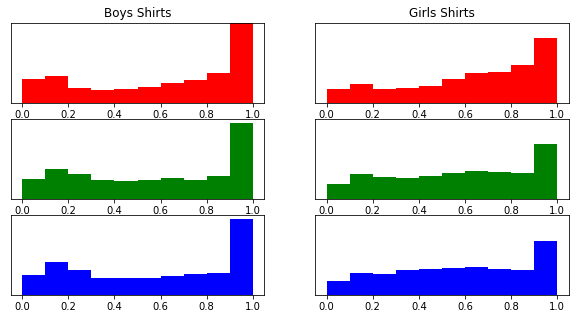

In [8]:
plt.figure(figsize =(10, 5))
plt.subplot(3, 2, 1)
plot_hist_normed(boys_display_images, 0, 'red')
plt.title('Boys Shirts')
plt.subplot(3, 2, 2)
plot_hist_normed(girls_display_images, 0, 'red')
plt.title('Girls Shirts')
plt.subplot(3, 2, 3)
plot_hist_normed(boys_display_images, 1, 'green')
plt.subplot(3, 2, 4)
plot_hist_normed(girls_display_images, 1, 'green')
plt.subplot(3, 2, 5)
plot_hist_normed(boys_display_images, 2, 'blue')
plt.subplot(3, 2, 6)
plot_hist_normed(girls_display_images, 2, 'blue')
plt.show()

In [9]:
def summary(images, channel, col):
    vals = images[:, :, :, channel].flatten()
    print('  %s mean: %.2f, median: %.2f, share above 0.9: %.2f' %(col, np.mean(vals), np.median(vals), np.mean(vals > 0.9)))
print('Boys:')
summary(boys_display_images, 0, 'red')
summary(boys_display_images, 1, 'green')
summary(boys_display_images, 2, 'blue')
print('Girls:')
summary(girls_display_images, 0, 'red')
summary(girls_display_images, 1, 'green')
summary(girls_display_images, 2, 'blue')

Boys:
  red mean: 0.63, median: 0.72, share above 0.9: 0.32
  green mean: 0.59, median: 0.62, share above 0.9: 0.28
  blue mean: 0.58, median: 0.62, share above 0.9: 0.28
Girls:
  red mean: 0.64, median: 0.70, share above 0.9: 0.24
  green mean: 0.58, median: 0.61, share above 0.9: 0.21
  blue mean: 0.58, median: 0.60, share above 0.9: 0.20


Girls and boys shirts have more or less the same level of color, whatever channel we look, mean or median.

However, boys shirts have more pixels with extreme red, blue or green values.

## Load 10% of data

In [10]:
def get_data_matrix(csv_file, folder, n = None):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n)
    images = read_images_4d_array(files_list)
    return images

x_boys_train = get_data_matrix('boys_train.csv', 'boys', 1000)
x_boys_test = get_data_matrix('boys_test.csv', 'boys', 250)
x_girls_train = get_data_matrix('girls_train.csv', 'girls', 1000)
x_girls_test = get_data_matrix('girls_test.csv', 'girls', 250)

y_boys_train = np.array([0] * x_boys_train.shape[0])
y_boys_test = np.array([0] * x_boys_test.shape[0])
y_girls_train = np.array([1] * x_girls_train.shape[0])
y_girls_test = np.array([1] * x_girls_test.shape[0])

## Single Predictor, Average Pixel

For each image get overall average pixel, and average for each of 3 channels:

In [11]:
def get_average_pixels(x):
    return np.hstack([x.mean(axis = (1, 2, 3)).reshape((-1, 1)), x.mean(axis = (1, 2))])
x_boys_train_av = get_average_pixels(x_boys_train)
x_boys_test_av = get_average_pixels(x_boys_test)
x_girls_train_av = get_average_pixels(x_girls_train)
x_girls_test_av = get_average_pixels(x_girls_test)

x_train = np.vstack([x_boys_train_av, x_girls_train_av])
x_test = np.vstack([x_boys_test_av, x_girls_test_av])
y_train = np.concatenate([y_boys_train, y_girls_train])
y_test = np.concatenate([y_boys_test, y_girls_test])

### Logistic Regression:

In [12]:
from sklearn.linear_model import LogisticRegression

def lr(dim, dim_name):
    mod = LogisticRegression()
    mod.fit(x_train[:, dim].reshape(-1, 1), y_train)
    acc = mod.score(x_test[:, dim].reshape(-1, 1), y_test)
    print('Accuracy of %s channel: %.2f' % (dim_name, acc))

lr(0, 'all')
lr(1, 'red')
lr(2, 'green')
lr(3, 'blue')

Accuracy of all channel: 0.50
Accuracy of red channel: 0.51
Accuracy of green channel: 0.51
Accuracy of blue channel: 0.52


Incredibly bad.

### Classification Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

def tr(dim, dim_name):
    mod = DecisionTreeClassifier()
    mod.fit(x_train[:, dim].reshape(-1, 1), y_train)
    acc = mod.score(x_test[:, dim].reshape(-1, 1), y_test)
    print('Accuracy of %s channel: %.2f' % (dim_name, acc))

tr(0, 'all')
tr(1, 'red')
tr(2, 'green')
tr(3, 'blue')

Accuracy of all channel: 0.49
Accuracy of red channel: 0.55
Accuracy of green channel: 0.52
Accuracy of blue channel: 0.51


Slightly better or the same.

## Multiple Predictors, Average Pixel

### Logistic Regression

In [14]:
mod = LogisticRegression()
mod.fit(x_train[:, 1:], y_train)
acc = mod.score(x_test[:, 1:], y_test)
print('Accuracy of LR on all channels: %.2f' % acc)
coef_names = ['red', 'green', 'blue']
coef = mod.coef_[0]
print('log-odds: %.2f + %.2f * %s + %.2f * %s + %.2f * %s' %
      (mod.intercept_, coef[0], coef_names[0], coef[1], coef_names[1], coef[2], coef_names[2]))

Accuracy of LR on all channels: 0.55
log-odds: -0.30 + 1.90 * red + -1.72 * green + 0.20 * blue


Slightly better.

### Classification Tree

In [15]:
mod = DecisionTreeClassifier()
mod.fit(x_train[:, 1:], y_train)
acc = mod.score(x_test[:, 1:], y_test)
print('Accuracy of CART on all channels: %.2f' % acc)

Accuracy of CART on all channels: 0.58


Trying to print the tree by copy-pasting [this](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html):

In [16]:
# Using those arrays, we can parse the tree structure:

n_nodes = mod.tree_.node_count
children_left = mod.tree_.children_left
children_right = mod.tree_.children_right
feature = mod.tree_.feature
threshold = mod.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 1193 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 0] <= 0.941295802593 else to node 1168.
	node=1 test node: go to node 2 if X[:, 0] <= 0.536408901215 else to node 407.
		node=2 test node: go to node 3 if X[:, 2] <= 0.443603217602 else to node 196.
			node=3 test node: go to node 4 if X[:, 0] <= 0.471794188023 else to node 155.
				node=4 test node: go to node 5 if X[:, 0] <= 0.435451537371 else to node 132.
					node=5 test node: go to node 6 if X[:, 2] <= 0.428569704294 else to node 131.
						node=6 test node: go to node 7 if X[:, 0] <= 0.365570306778 else to node 72.
							node=7 test node: go to node 8 if X[:, 1] <= 0.31470233202 else to node 49.
								node=8 test node: go to node 9 if X[:, 1] <= 0.297568947077 else to node 46.
									node=9 test node: go to node 10 if X[:, 0] <= 0.128530442715 else to node 11.
										node=10 leaf node.
										node=11 test node: go to node 12 if X[:, 0] <= 0.29165983200

															node=859 leaf node.
															node=860 test node: go to node 861 if X[:, 0] <= 0.633118748665 else to node 862.
																node=861 leaf node.
																node=862 test node: go to node 863 if X[:, 1] <= 0.780588269234 else to node 868.
																	node=863 test node: go to node 864 if X[:, 1] <= 0.676449298859 else to node 867.
																		node=864 test node: go to node 865 if X[:, 2] <= 0.725848197937 else to node 866.
																			node=865 leaf node.
																			node=866 leaf node.
																		node=867 leaf node.
																	node=868 leaf node.
														node=869 leaf node.
													node=870 leaf node.
										node=871 test node: go to node 872 if X[:, 1] <= 0.662112832069 else to node 873.
											node=872 leaf node.
											node=873 test node: go to node 874 if X[:, 0] <= 0.679626226425 else to node 875.
												node=874 leaf node.
												node=875 test node: go to node 876 if X[:, 0] <= 0.7321

															node=1049 test node: go to node 1050 if X[:, 0] <= 0.861780524254 else to node 1051.
																node=1050 leaf node.
																node=1051 test node: go to node 1052 if X[:, 0] <= 0.871819198132 else to node 1055.
																	node=1052 test node: go to node 1053 if X[:, 1] <= 0.817499399185 else to node 1054.
																		node=1053 leaf node.
																		node=1054 leaf node.
																	node=1055 test node: go to node 1056 if X[:, 0] <= 0.915274381638 else to node 1057.
																		node=1056 leaf node.
																		node=1057 test node: go to node 1058 if X[:, 2] <= 0.82192337513 else to node 1059.
																			node=1058 leaf node.
																			node=1059 leaf node.
														node=1060 leaf node.
												node=1061 test node: go to node 1062 if X[:, 1] <= 0.941524386406 else to node 1167.
													node=1062 test node: go to node 1063 if X[:, 2] <= 0.83820027113 else to node 1068.
														node=1063 test n